# GDELT News Data Extraction for GTA Area - Aggregated Daily

## Download list of news files

### Environment:
 - Python: 3.5.5
 - gensim
 - conda install -c conda-forge newspaper3k
 - spacy
 - conda install -c conda-forge pyldavis
 - conda install -c conda-forge wordcloud

In [3]:
import warnings
warnings.filterwarnings('ignore')

import requests
import lxml.html as lh

gdelt_base_url = 'http://data.gdeltproject.org/events/'

# get the list of all the links on the gdelt file page
page = requests.get(gdelt_base_url+'index.html')
doc = lh.fromstring(page.content)
link_list = doc.xpath("//*/ul/li/a/@href")

# separate out those links that begin with four digits 
file_list = [x for x in link_list if str.isdigit(x[0:4])]

# preview the list
file_list[0:5]

['20190410.export.CSV.zip',
 '20190409.export.CSV.zip',
 '20190408.export.CSV.zip',
 '20190407.export.CSV.zip',
 '20190406.export.CSV.zip']

## Input Data

In [4]:
# geo-fence
lt1 = 43.403221
lt2 = 43.855401
lg1 = -79.639319
lg2 = -78.905820

# days back to process
days_back = 1

## Extract Relevant GDELT Rows

In [5]:
import os.path
import urllib
import zipfile
import glob
import operator

infilecounter = 0
outfilecounter = 0

dir_path = os.getcwd()
print ('Working dir: ' + dir_path)
                          
# make some dirs
local_path = dir_path + '\\'
if not os.path.exists(local_path+'data'):
    os.makedirs(local_path+'data')
if not os.path.exists(local_path+'gta-data'):
    os.makedirs(local_path+'gta-data')
    
for compressed_file in file_list[infilecounter:]:
    print ('data\\'+compressed_file),
    
    # if we dont have the compressed file stored locally, go get it. Keep trying if necessary.
    while not os.path.isfile(local_path+'data\\'+compressed_file): 
        print ('...downloading,'),
        urllib.request.urlretrieve(url=gdelt_base_url+compressed_file, 
                                   filename=local_path+'data\\'+compressed_file)
        
    # extract the contents of the compressed file to a temporary directory    
    print ('...extracting,'),
    z = zipfile.ZipFile(file=local_path + 'data\\' + compressed_file, mode='r')    
    z.extractall(path=local_path + 'tmp/')
    
    # parse each of the csv files in the working directory, 
    print ('...parsing,'),
    for infile_name in glob.glob(local_path + 'tmp/*'):
        outfile_name = local_path + 'gta-data\\' + 'gta' + '%04i.tsv'%outfilecounter    
    
        # open the infile and outfile
        with open(infile_name,  mode='r', encoding="utf8") as infile, \
             open(outfile_name, mode='w', encoding="utf8") as outfile:
            
            for line in infile:
                vals = line.split('\t')
                
                # extract geo-coordinates
                try:
                    lat  = float(vals[53]) # ActionGeo_Lat
                    long = float(vals[54]) # ActionGeo_Long
                except Exception as e:
                    # means no coordinates provided, skipping
                    continue
                
                # only use events inside geo-fence
                if  long >= lg1 and long <= lg2 and lat >= lt1 and lat <= lt2:
                    outfile.write(line)
                
            outfilecounter +=1
            
        # delete the temporary file
        os.remove(infile_name)
        
    infilecounter +=1
    if infilecounter >= days_back:
        print ('done')
        break

Working dir: C:\Users\ibaranov\Downloads\York\group-projects\CSDA1050-CAP\playground\GDELT2
data\20190410.export.CSV.zip
...downloading,
...extracting,
...parsing,
done


## Create dataframe with GDELT news info

In [6]:
import glob
import pandas as pd

# Get the GDELT field names from an external helper file
colnames = pd.read_excel('CSV.header.fieldids.xlsx', sheet_name='Sheet1', 
                         index_col='Column ID', usecols=1)['Field Name']

# Build DataFrames from each of the intermediary files
files = glob.glob(local_path+'gta-data/'+'*')
DFlist = []
for active_file in files:
    print (active_file)
    DFlist.append(pd.read_csv(active_file, sep='\t', header=None, dtype=str,
                              names=colnames, index_col=['GLOBALEVENTID']))

# Merge the file-based dataframes and serialize the dataframe
DF = pd.concat(DFlist)
DF.to_pickle(local_path+'backup'+'-gta'+'.pickle')    
    
# remove the temporary files
for active_file in files:
    os.remove(active_file)

C:\Users\ibaranov\Downloads\York\group-projects\CSDA1050-CAP\playground\GDELT2\gta-data\gta0000.tsv


## Text cleaning function

In [7]:
import spacy
from spacy.lang.en import English

parser = English()
def tokenize(text):
    lda_tokens = []
    tokens = parser(text)
    for token in tokens:
        if token.orth_.isspace():
            continue
        elif token.like_url:
            lda_tokens.append('URL')
        elif token.orth_.startswith('@'):
            lda_tokens.append('SCREEN_NAME')
        else:
            lda_tokens.append(token.lower_)
    return lda_tokens

## Use NLTK’s Wordnet to find the meanings of words 

In [8]:
import nltk
nltk.download('wordnet')
from nltk.corpus import wordnet as wn
def get_lemma(word):
    lemma = wn.morphy(word)
    if lemma is None:
        return word
    else:
        return lemma
    
from nltk.stem.wordnet import WordNetLemmatizer
def get_lemma2(word):
    return WordNetLemmatizer().lemmatize(word)

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\ibaranov\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Filter out stop words

In [9]:
nltk.download('stopwords')
en_stop = set(nltk.corpus.stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ibaranov\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Function to prepare the text for topic modelling

In [10]:
def prepare_text_for_lda(text):
    tokens = tokenize(text)
    tokens = [token for token in tokens if len(token) > 4]
    tokens = [token for token in tokens if token not in en_stop]
    tokens = [get_lemma(token) for token in tokens]
    return tokens

## For each news link

In [11]:
from newspaper import Article
import random

dfc = DF.sort_values('SOURCEURL').groupby('SOURCEURL').first()
print("Found " + str(len(dfc)) + " unique news links")

text_data = []
for index, row in dfc.iterrows():
    print(row.name)
    
    try:
        # get article text
        article = Article(row.name)
        article.download()
        article.parse()

        #extract tokensm show some
        tokens = prepare_text_for_lda(article.text)
        if random.random() > .5:
            print(tokens[1:10])

        text_data.append(tokens)
    except Exception as e:
        print ("Some error processing the URL.. skipped")
        continue
    

Found 214 unique news links
http://collider.com/shazam-superman-cameo-henry-cavill/
http://diymag.com/2019/04/10/pup-morbid-stuff-interview-preview
http://entrevestor.com/blog/3-halifax-startups-head-to-collision
['halifax', 'startup', 'select', 'showcase', 'business', 'collision', 'toronto', 'conference', 'call']
http://entrevestor.com/blog/deloitte-opens-fast-50-applications
http://exclaim.ca/music/article/julian_casablancas_thinks_streaming_services_are_a_waste_of_time
http://hardware.itbusinessnet.com/2019/04/mpx-international-acquires-holyweed-a-swiss-premium-organic-cannabis-company/
http://ktar.com/story/2523110/queen-inspired-musical-tour-we-will-rock-you-to-stop-in-prescott-this-fall/
http://mondaq.com/canada/x/797800/Corporate+Commercial+Law/Continued+Robust+VC+Investment+And+PE+MegaDeals+Take+The+Spotlight+In+A+Review+Of+The+2018+VC+PE+Canadian+Market
http://oshawaexpress.ca/feature-a-starr-is-born-the-story-of-canadas-first-ukrainian-cabinet-minister/
http://star977.com/201

https://theprovince.com/news/local-news/goldstein-fords-priority-should-be-balancing-the-budget/wcm/28e81e30-a26b-42b3-9c17-f2919b470a6a
https://thewolf.ca/news/5152265/peterborough-hospital-volunteer-honoured-50-years-of-service/
['volunteer', 'peterborough', 'hospital', 'years', 'peterborough', 'woman', 'recognize', 'wednesday', 'years']
https://toronto.ctvnews.ca/ford-s-28-5b-transit-plan-will-double-size-of-downtown-relief-line-dubbed-ontario-line-1.4373484
https://toronto.ctvnews.ca/musician-who-has-never-taken-a-lesson-surprises-customers-in-toronto-stores-1.4373114
https://toronto.ctvnews.ca/police-charge-18-year-old-with-attempted-murder-after-shots-fired-near-school-1.4373717
https://toronto.ctvnews.ca/police-search-for-two-suspects-in-connection-with-carjackings-in-north-york-1.4374357
['herhalt', 'toronto', 'police', 'release', 'surveillance', 'camera', 'image', 'want', 'woman']
https://toronto.ctvnews.ca/premier-to-unveil-details-of-28-5b-transit-plan-but-toronto-s-mayor-wo

['declerq', 'believe', 'teens', 'transport', 'hospital', 'shooting', 'carleton', 'village', 'neighbourhood']
https://www.cp24.com/news/province-unveils-plans-to-alter-four-big-toronto-transit-projects-1.4373196
https://www.cp24.com/news/provincial-government-set-to-announce-28-5-billion-in-transit-funding-for-gta-1.4373196
https://www.ctvnews.ca/politics/liberal-mps-call-on-tories-to-cancel-250-a-head-business-of-healthcare-fundraiser-1.4374502
https://www.dailymail.co.uk/health/article-6906929/Man-develops-kidney-failure-taking-12-TIMES-recommended-vitamin-D.html
['kidney', 'failure', 'taking', 'times', 'recommend', 'amount', 'vitamin', 'every', 'unnamed']
https://www.dailymail.co.uk/tvshowbiz/article-6906399/Drake-Usain-Bolt-arrive-Tape-nightclub-London-lads-night-out.html
https://www.dailypolitical.com/2019/04/10/patriot-financial-group-insurance-agency-llc-sells-6865-shares-of-general-electric-ge.html
['financial', 'group', 'insurance', 'agency', 'decrease', 'holding', 'general', '

https://www.prweb.com/releases/panviva_enters_the_canadian_market_to_help_companies_deliver_exceptional_customer_experience_meet_the_team_at_customer_experience_strategies_summit_toronto/prweb16232639.htm
['almost', 'customer', 'increasingly', 'using', 'digital', 'channels', 'expect', 'consistent', 'response']
https://www.record-eagle.com/nation_world/canada-s-ex-attorney-general-ousted-from-trudeau-s-caucus/article_147ec76b-4c51-5ee8-a917-38bb51f44071.html
['49684', 'today', 'cloudy', 'developing', 'midnight', 'wind', 'chance', 'rainfall', 'quarter']
https://www.samaa.tv/news/2019/04/pia-air-hostess-goes-missing-in-paris/
https://www.saultstar.com/news/local-news/audit-of-aph-hiring-of-ex-con-should-be-public-court-rules
['public', 'interest', 'algoma', 'public', 'health', 'hire', 'convict', 'fraudster', 'serve']
https://www.saultstar.com/news/local-news/chamber-hopes-provincial-budget-doesnt-risk-long-term-economic-growth
https://www.saultstar.com/news/local-news/former-saultite-expa

['housing', 'market', 'trade', 'place', 'since', 'crisis', 'decade', 'international', 'monetary']
https://www.yahoo.com/lifestyle/why-gabrielle-union-dwyane-wades-191200465.html


##  Identify unique news locations

In [76]:
DF.groupby(['ActionGeo_Lat','ActionGeo_Long'], as_index=False).first() \
    [['ActionGeo_Lat','ActionGeo_Long','ActionGeo_FullName']]

,ActionGeo_Lat,ActionGeo_Long,ActionGeo_FullName
0,43.55,-79.5833,"Port Credit, Ontario, Canada"
1,43.6667,-79.4167,"Toronto, Ontario, Canada"
2,43.7,-79.5667,"Etobicoke, Ontario, Canada"
3,43.7333,-79.3333,"Don Mills, Ontario, Canada"


## LDA with Gensim

In [12]:
from gensim import corpora
dictionary = corpora.Dictionary(text_data)
corpus = [dictionary.doc2bow(text) for text in text_data]

## Serialize the dictionary for future use

In [13]:
import pickle
pickle.dump(corpus, open('corpus.pkl', 'wb'))
dictionary.save('dictionary.gensim')

## LDA to find 5 topics in the data

In [88]:
import gensim
NUM_TOPICS = 30
ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics = NUM_TOPICS, id2word=dictionary, passes=15)
ldamodel.save('model5.gensim')
topics = ldamodel.print_topics(num_words=5)
for topic in topics:
    print(topic)

(2, '0.043*"police" + 0.022*"toronto" + 0.018*"vehicle" + 0.018*"charge" + 0.014*"arrest"')
(14, '0.028*"ontario" + 0.020*"government" + 0.019*"transit" + 0.018*"toronto" + 0.018*"province"')
(6, '0.014*"cobalt" + 0.012*"statement" + 0.012*"company" + 0.012*"market" + 0.011*"looking"')
(20, '0.013*"canadian" + 0.013*"canada" + 0.010*"banks" + 0.009*"share" + 0.009*"housing"')
(28, '0.020*"student" + 0.017*"israel" + 0.013*"jewish" + 0.012*"campus" + 0.011*"university"')
(13, '0.021*"price" + 0.014*"store" + 0.012*"staple" + 0.008*"business" + 0.008*"product"')
(19, '0.021*"hindu" + 0.012*"centre" + 0.011*"india" + 0.010*"toronto" + 0.008*"speaker"')
(17, '0.014*"month" + 0.012*"years" + 0.010*"ashkani" + 0.009*"palm" + 0.008*"access"')
(18, '0.014*"toronto" + 0.012*"pedroia" + 0.009*"solution" + 0.009*"muzzi" + 0.008*"elevator"')
(4, '0.011*"technology" + 0.011*"conference" + 0.010*"toronto" + 0.010*"school" + 0.009*"medicine"')
(1, '0.015*"engagement" + 0.013*"mondaq" + 0.009*"content

## Visualizing topics with pyLDAvis

In [89]:
dictionary = gensim.corpora.Dictionary.load('dictionary.gensim')
corpus = pickle.load(open('corpus.pkl', 'rb'))
lda = gensim.models.ldamodel.LdaModel.load('model5.gensim')

import pyLDAvis.gensim
lda_display = pyLDAvis.gensim.prepare(lda, corpus, dictionary, sort_topics=False)
pyLDAvis.display(lda_display)

## Sentiment analysis

In [81]:
from textblob import TextBlob

todays_text = " ".join(map(str, text_data))

blob = TextBlob(todays_text)
blob.sentiment

Sentiment(polarity=0.060608216865642876, subjectivity=0.4033898987109196)

## Word Cloud

(-0.5, 399.5, 199.5, -0.5)

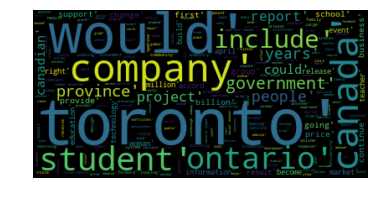

In [34]:
from wordcloud import WordCloud
wordcloud = WordCloud().generate(todays_text)

import matplotlib.pyplot as plt
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")